In [ ]:
!pip install "numpy<2.0" -q

In [ ]:
!pip install tensorflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.6/620.6 MB 944.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 22.1 MB/s eta 0:00:00


In [5]:
!pip install --upgrade datasets numpy

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
import tensorflow as tf
from datasets import Dataset
import re
import nltk
from transformers import EarlyStoppingCallback
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
transformers.__version__

'4.53.2'

In [33]:
tf.__version__

'2.18.0'

##*`load dataset`*

In [8]:
data= pd.read_csv('cellula toxic data .csv',encoding='UTF-8')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   query               3000 non-null   object
 1   image descriptions  3000 non-null   object
 2   Toxic Category      3000 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB


In [9]:
data.shape

(3000, 3)

In [10]:
data.columns = data.columns.str.strip().str.replace(' ', '_')
data.head()

,query,image_descriptions,Toxic_Category
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections


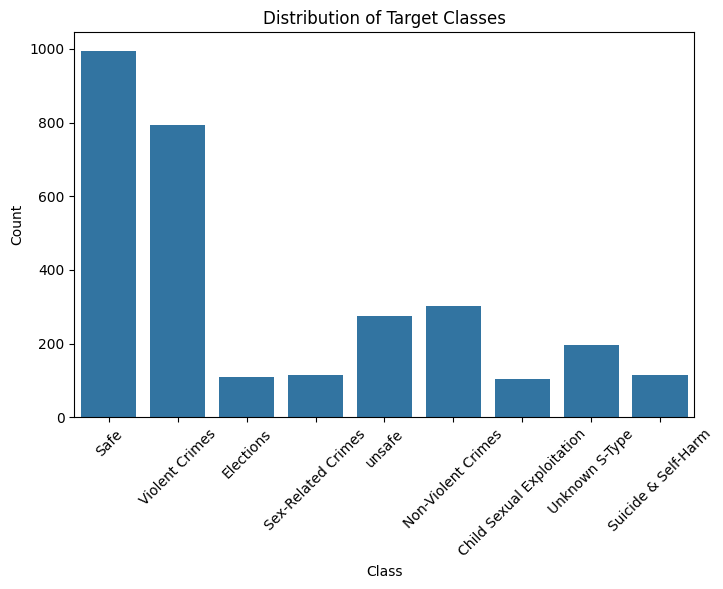

In [11]:
plt.figure(figsize=(8,5))
sns.countplot(x='Toxic_Category', data=data)
plt.xticks(rotation=45)
plt.title('Distribution of Target Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [12]:
# Create label encoding
unique_labels = sorted(data['Toxic_Category'].unique())
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

for label, idx in label2id.items():
    print(f"  {label}: {idx}")


  Child Sexual Exploitation: 0
  Elections: 1
  Non-Violent Crimes: 2
  Safe: 3
  Sex-Related Crimes: 4
  Suicide & Self-Harm: 5
  Unknown S-Type: 6
  Violent Crimes: 7
  unsafe: 8


In [13]:
# Encode labels
data['label'] = data['Toxic_Category'].map(label2id)

In [14]:
data.head()

,query,image_descriptions,Toxic_Category,label
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe,3
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe,3
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe,3
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes,7
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections,1


##*`Split dataset`*

In [15]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['query'].astype(str).values,
    data['label'].astype(int).values,
    test_size=0.2,
    random_state=42,
    stratify=data['label']
)

In [16]:
len(train_texts), len(test_texts)

(2400, 600)

In [17]:
# Create dataset dictionaries
train_dict = {
    'text': train_texts,
    'label': train_labels
}

test_dict = {
    'text': test_texts,
    'label': test_labels
}

train_data = Dataset.from_dict(train_dict)
test_data = Dataset.from_dict(test_dict)

##*`Tokanize data`*

In [18]:
data['query'].str.split().str.len().describe()

,query
count,3000.000000
mean,12.874667
std,7.142826
min,2.000000
25%,10.000000
50%,12.000000
75%,13.000000
max,140.000000


In [19]:
MAX_SEQ_LEN = 64
BATCH_SIZE = 32
MODEL_NAME = "distilbert-base-uncased"

In [20]:
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [21]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=MAX_SEQ_LEN
    )

In [22]:
train_dataset = train_data.map(tokenize_function, batched=True)
test_dataset = test_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [23]:
# Set format to PyTorch tensors
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

##*`Build model`*

In [24]:
DistilBERT_model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=9,
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
# LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,  # Increase from 4
    lora_alpha=16,  # Increase from 8 #Scaling factor alpha/r
    lora_dropout=0.1, #prevent overfitting
    bias="none",
    target_modules=["q_lin", "v_lin"],  # Apply LoRA to attention layers q_lin -> Query projection  v_lin -> Value projection
)

In [45]:
# Apply LoRA
model = get_peft_model(DistilBERT_model, lora_config)
model.print_trainable_parameters()

trainable params: 744,969 || all params: 67,705,362 || trainable%: 1.1003


In [46]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1_macro': f1_score(labels, predictions, average='macro'),
        'f1_weighted': f1_score(labels, predictions, average='weighted')
    }

In [47]:
training_args = TrainingArguments(
    output_dir='./DistilBERT-results',  # Directory where checkpoints and final model will be saved
    num_train_epochs=10,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=100,  # Reduce from 200   # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # L2 regularization to reduce overfitting
    logging_steps=50,   # Log training loss every 50 steps
    eval_strategy="epoch",  # Run evaluation once at the end of each epoch
    save_strategy="epoch",      # Save a checkpoint at the end of each epoch
    load_best_model_at_end=True,  # Automatically reload the best model after training Based on `metric_for_best_model`
    metric_for_best_model='f1_weighted',  # f1_weighted is ideal for imbalanced classification tasks
    learning_rate=2e-4,
    save_total_limit=2, #Maximum number of checkpoints to keep, Older checkpoints are deleted automatically
    report_to="none",
)

In [ ]:
early_stop = EarlyStoppingCallback(
    early_stopping_patience=2,
)

In [49]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[early_stop],
    compute_metrics=compute_metrics
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [50]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.191400,0.812912,0.690000,0.735175,0.655515
2,0.684200,0.689847,0.731667,0.803922,0.725355
3,0.596100,0.689339,0.736667,0.805142,0.724034
4,0.598200,0.662600,0.730000,0.805148,0.727391
5,0.548300,0.658642,0.733333,0.804923,0.728914
6,0.516800,0.664205,0.743333,0.808983,0.736375
7,0.489200,0.675376,0.738333,0.808051,0.729694
8,0.486600,0.662094,0.741667,0.808644,0.735686


TrainOutput(global_step=600, training_loss=0.6385945256551107, metrics={'train_runtime': 82.4778, 'train_samples_per_second': 290.987, 'train_steps_per_second': 9.093, 'total_flos': 323453952000000.0, 'train_loss': 0.6385945256551107, 'epoch': 8.0})

In [52]:
test_results = trainer.evaluate(test_dataset)
print("Test Results:")
for key, value in test_results.items():
    print(f"  {key}: {value:.4f}")

predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

print(classification_report(
    test_labels,
    predicted_labels,
    target_names=[id2label[i] for i in range(9)],
    digits=4
))

Test Results:
  eval_loss: 0.6642
  eval_accuracy: 0.7433
  eval_f1_macro: 0.8090
  eval_f1_weighted: 0.7364
  eval_runtime: 1.0731
  eval_samples_per_second: 559.1380
  eval_steps_per_second: 17.7060
  epoch: 8.0000
                           precision    recall  f1-score   support

Child Sexual Exploitation     1.0000    1.0000    1.0000        21
                Elections     1.0000    1.0000    1.0000        22
       Non-Violent Crimes     0.8125    0.4333    0.5652        60
                     Safe     0.7303    0.8844    0.8000       199
       Sex-Related Crimes     1.0000    1.0000    1.0000        23
      Suicide & Self-Harm     1.0000    1.0000    1.0000        23
           Unknown S-Type     0.8571    0.4615    0.6000        39
           Violent Crimes     0.5876    0.6582    0.6209       158
                   unsafe     0.8250    0.6000    0.6947        55

                 accuracy                         0.7433       600
                macro avg     0.8681    0.78

In [53]:
def predict_toxicity(text, model, tokenizer):
    device = next(model.parameters()).device
    model.eval()

    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][predicted_class].item()

    return id2label[predicted_class], confidence

# Test examples
print("\n=== Example Predictions ===")
test_examples = [
    "What are the health benefits of exercise?",
    "How do I hack someone's account?",
    "Tell me about real estate investment strategies.",
]

for text in test_examples:
    category, confidence = predict_toxicity(text, model, tokenizer)
    print(f"\nText: {text}")
    print(f"Category: {category}")
    print(f"Confidence: {confidence:.4f}")


=== Example Predictions ===

Text: What are the health benefits of exercise?
Category: Safe
Confidence: 0.9269

Text: How do I hack someone's account?
Category: Violent Crimes
Confidence: 0.8298

Text: Tell me about real estate investment strategies.
Category: Violent Crimes
Confidence: 0.4963
